# Stock Feature Pipeline

This notebook converts the raw data from the apis into model inputs


In [1]:
# Import the required libraries and load in the environment variables
import hopsworks
import os
from dotenv import load_dotenv

import requests
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import CCIIndicator

plt.style.use('grayscale')

# Load the .env file
load_dotenv()

# Get the environment variables
tiingo_api_key = os.getenv("TIINGO_API_KEY")
hopsworks_api_key = os.getenv("HOPSWORKS_API_KEY")
alpha_vantage_key = os.getenv("ALPHA_VANTAGE_KEY")

### Getting Data From API


#### Generate Dataset from API getting last year data


In [2]:

def create_dataset_chunk(start_date: str, end_date: str, ticker="AMZN", freq: str = '60min') -> pd.DataFrame:

    # Format the url with start_data, end_data and freq
    url = f"https://api.tiingo.com/iex/{ticker}/prices?startDate={start_date}&endDate={end_date}&resampleFreq={freq}&token={tiingo_api_key}"
    response = requests.get(url).json()

    return pd.DataFrame(response)


# df = create_dataset_chunk("2024-01-01", "2024-02-29")  # Test the function

In [3]:
years = [2019, 2020, 2021, 2022, 2023, 2024]

for i in range(len(years) - 1):
    print(years[i], years[i + 1])

2019 2020
2020 2021
2021 2022
2022 2023
2023 2024


In [4]:

def create_supervised_dataset(years: list, ticker: str = "AMZN", freq: str = '60min') -> pd.DataFrame:
    """
    Generates a supervised dataset from DataFrame chunks based on the provided date ranges.

    Args:
        dates (dict): A dictionary where keys are start dates and values are end dates.
        ticker (str): The stock ticker symbol. Default is "AMZN".
        freq (str): The frequency of the data. Default is '60min'.

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data for all date ranges.
    """
    # Initialize an empty DataFrame to store the concatenated data
    data = pd.DataFrame()

    # Iterate over each date range in the dates dictionary
    for i in tqdm(range(len(years) - 1)):
        # Create a DataFrame chunk for the given date range, ticker, and frequency
        df = create_dataset_chunk(
            start_date=f"{years[i]}-01-01", end_date=f"{years[i+1]}-12-31", ticker=ticker, freq=freq)

        # Concatenate the new chunk with the existing data
        data = pd.concat([data, df])

        # Get the current year stock market data
    data = pd.concat([data, create_dataset_chunk('2025-01-01', '2025-02-18')])

    # Change the date column to datetime format
    data['date'] = data['date'].map(lambda x: x.split('.')[0])
    data['date'] = pd.to_datetime(data['date'])

    # Set the index as the date column
    data = data.set_index("date")
    # Return the concatenated DataFrame
    return data.sort_index()

In [5]:
# Call the function
data = create_supervised_dataset(years, "AMZN")

data.head()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


,close,high,low,open
date,,,,
2019-01-02 15:00:00,1515.03,1518.000,1479.59,1486.18
2019-01-02 16:00:00,1513.50,1529.825,1513.18,1516.40
2019-01-02 17:00:00,1533.50,1533.500,1512.93,1513.01
2019-01-02 18:00:00,1549.00,1553.090,1533.93,1533.93
2019-01-02 19:00:00,1543.23,1552.660,1539.15,1547.68


In [6]:
data.head(10)

,close,high,low,open
date,,,,
2019-01-02 15:00:00,1515.030,1518.000,1479.590,1486.180
2019-01-02 16:00:00,1513.500,1529.825,1513.180,1516.400
2019-01-02 17:00:00,1533.500,1533.500,1512.930,1513.010
2019-01-02 18:00:00,1549.000,1553.090,1533.930,1533.930
2019-01-02 19:00:00,1543.230,1552.660,1539.150,1547.680
2019-01-02 20:00:00,1538.400,1544.165,1531.825,1540.190
2019-01-03 15:00:00,1515.715,1522.350,1503.125,1520.500
2019-01-03 16:00:00,1529.000,1532.670,1514.575,1515.715
2019-01-03 17:00:00,1522.040,1533.530,1520.420,1529.000


In [7]:
data.tail()

,close,high,low,open
date,,,,
2025-02-18 16:00:00,224.360,225.605,224.245,225.550
2025-02-18 17:00:00,225.020,225.050,223.840,224.360
2025-02-18 18:00:00,224.275,225.245,223.740,225.025
2025-02-18 19:00:00,224.510,224.690,223.750,224.275
2025-02-18 20:00:00,226.640,226.640,224.270,224.515


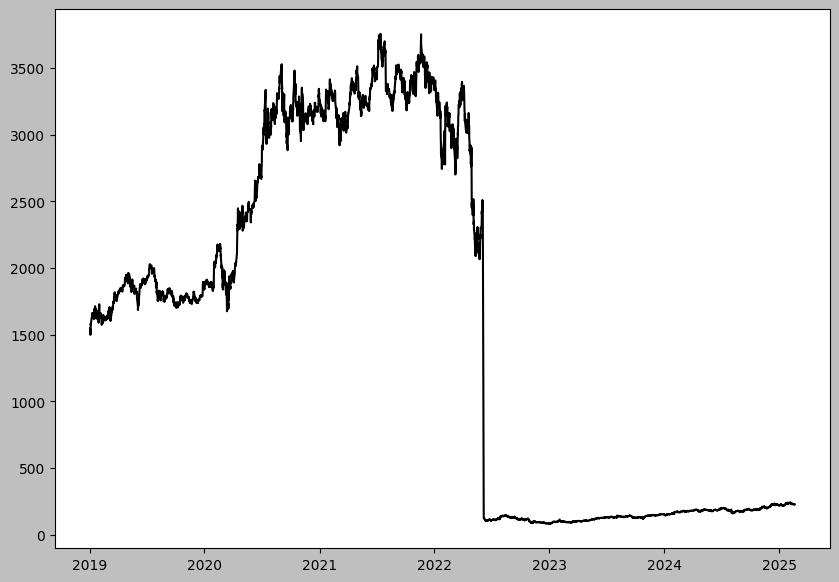

In [8]:

plt.figure(figsize=(10, 7))
plt.plot(data.index, data["close"])
plt.show()

## Data Ingestion to Feature Store


In [9]:
# reset the index 
data = data.reset_index()

# Add the id column as primary key
data["id"] = [str(date) for date in data['date']]

In [13]:
data.head()

,date,close,high,low,open,id
0,2019-01-02 15:00:00,1515.03,1518.000,1479.59,1486.18,2019-01-02 15:00:00
1,2019-01-02 16:00:00,1513.50,1529.825,1513.18,1516.40,2019-01-02 16:00:00
2,2019-01-02 17:00:00,1533.50,1533.500,1512.93,1513.01,2019-01-02 17:00:00
3,2019-01-02 18:00:00,1549.00,1553.090,1533.93,1533.93,2019-01-02 18:00:00
4,2019-01-02 19:00:00,1543.23,1552.660,1539.15,1547.68,2019-01-02 19:00:00


In [11]:
# Login to Hopsworks
project = hopsworks.login(api_key_value = str(hopsworks_api_key))

# Get the feature store
fs = project.get_feature_store()

2025-02-20 17:52:19,203 INFO: Initializing external client
2025-02-20 17:52:19,204 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-20 17:52:22,975 INFO: Python Engine initialized.


KeyboardInterrupt: 

In [ ]:
# Create feature group
amazon_fg = fs.get_or_create_feature_group(
    name="amazon_stock_prices",
    description="Amazon last 5 year stock prices",
    version=1,
    online_enabled=True,
    primary_key=["id"],
    event_time="date"
)

# Insert into feature group
amazon_fg.insert(data)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1212597/fs/1200226/fg/1401055


Uploading Dataframe: 100.00% |██████████| Rows 15834/15834 | Elapsed Time: 00:04 | Remaining Time: 00:00


Launching job: amazon_stock_prices_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1212597/jobs/named/amazon_stock_prices_1_offline_fg_materialization/executions


(Job('amazon_stock_prices_1_offline_fg_materialization', 'SPARK'), None)

In [ ]:
# Create a list of dictionaries with column names and descriptions
column_descriptions = [
    {'name': 'date', 'description': 'The date and time of the stock data'},
    {'name': 'close', 'description': 'The closing price of the stock'},
    {'name': 'high', 'description': 'The highest price of the stock during the period'},
    {'name': 'low', 'description': 'The lowest price of the stock during the period'},
    {'name': 'open', 'description': 'The opening price of the stock'},
    {'name': 'id', 'description': 'primary key'}
]

for desc in column_descriptions:
    amazon_fg.update_feature_description(desc['name'], desc['description'])